In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

In [3]:
# Create and run a project. Explore different processing parameters (smoothing, imputation)

In [45]:
my_deepof_project = deepof.data.Project(
                path=os.path.join("tests/test_examples/test_multi_topview/"),
                arena="circular-autodetect",
                animal_ids=["B", "W"],
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                enable_iterative_imputation=True,
#                 exp_conditions={
#                     '20191204_Day2_SI_JB08_Test_56': 'Stressed',
#                     '20191204_Day2_SI_JB08_Test_61': 'Stressed',
#                     '20191204_Day2_SI_JB08_Test_62': 'Stressed',
#                     '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
#                     '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
#                     '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'
#                 }
)

# Set manually the edge in the polygons that we're measuring

In [46]:
my_deepof_project = my_deepof_project.run()

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Detecting arena...
Computing distances...
Computing angles...
Computing areas...
Done!


In [64]:
my_deepof_project.get_areas(speed=0, selected_id="all")['test2']

,B_head_area,B_torso_area,B_back_area,B_full_area,W_head_area,W_torso_area,W_back_area,W_full_area
0,185.937543,406.915426,556.100932,1608.839992,166.331030,418.254489,580.388770,1639.025147
1,182.835210,378.185692,513.223991,1541.499641,186.152026,452.064389,599.816567,1743.292072
2,186.963663,376.624710,486.708852,1522.280139,159.763380,446.778940,589.094645,1688.978951
3,187.361295,396.049662,483.312904,1502.877038,148.784253,405.249972,568.174648,1615.748155
4,170.872134,376.270958,492.361266,1460.261605,159.633541,419.265038,597.064425,1706.681608
...,...,...,...,...,...,...,...,...
93,218.248548,282.896686,331.779917,1281.238309,193.909573,511.830478,590.753611,1775.596361
94,243.288773,219.850395,331.336036,1314.125272,201.332629,466.108484,532.018396,1649.609150
95,244.320292,223.570536,322.497036,1285.395181,174.638187,448.492326,528.489503,1534.649296
96,244.320292,223.570536,322.497036,1285.395181,174.638187,448.492326,528.489503,1534.649296


In [6]:
# Save your project to avoid laborious repetitions

In [7]:
my_deepof_project.save("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates")

AttributeError: 'Project' object has no attribute 'save'

In [17]:
# Load a previously saved project
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates_1667951748.pkl")

In [23]:
my_deepof_project.get_dista

AttributeError: 'Coordinates' object has no attribute '_distances'

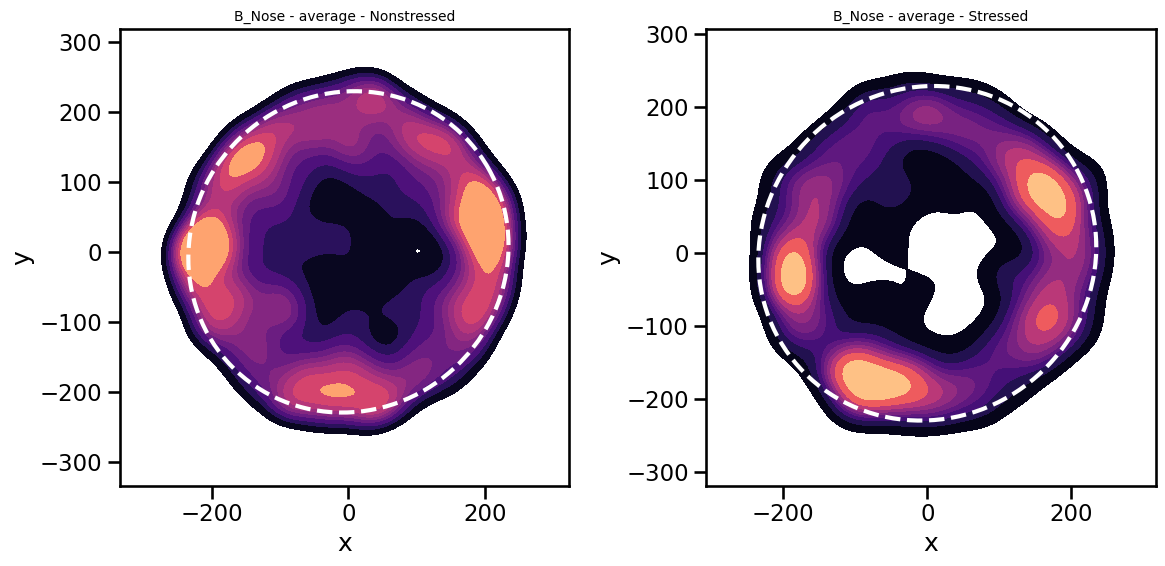

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import deepof.visuals
from matplotlib.patches import Ellipse

sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

In [10]:
# Multi animal display

In [11]:
from sklearn.decomposition import PCA
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords()['20191204_Day2_SI_JB08_Test_56'])

In [12]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Single animal display

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords().filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    center="Center",
    align="Spine_1",
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [ ]:
my_deepof_project.get_coords(polar=True)['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_areas()

In [ ]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
# Show how to merge different feature objects

my_deepof_project.get_coords().pca()